# Simulation studies using Hastie's data

The goal of this simulation study is to see how the performance of the Bayesian-encoded model varies for different values of the hyperparameters. 


In [1]:
%load_ext autoreload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys,os, pathlib
current = pathlib.Path(os.getcwd())
base = current.parent.parent
catenc = base.joinpath('categorical-encoding')
sys.path.append(str(catenc))

# Binary classification problem

For Binary classifier we will work with the example 10.2 of T. Hastie, R. Tibshirani and J. Friedman, "Elements of Statistical Learning Ed. 2", Springer, 2009.

In [3]:
from sklearn.datasets import make_hastie_10_2
X_h, y_h = make_hastie_10_2(random_state=2834)
X_h = X_h.astype('float16')
y_h[y_h==-1]=0

In [4]:
#Now convert the last column to the categorical
from sklearn.preprocessing import KBinsDiscretizer
disczr1 = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
cat_column1 = disczr1.fit_transform(X_h[:,-1].reshape(-1, 1)) * 193 % 20 #We want to break the monotonicity
disczr2 = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='uniform')
cat_column2 = disczr2.fit_transform(X_h[:,-2].reshape(-1, 1)) * 173 % 20 #We want to break the monotonicity

In [5]:
predictors = pd.DataFrame(X_h[:, 0:-2], columns=[f'col_{i}' for i in range(8)])
predictors['cat1'] = cat_column1
predictors['cat2'] = cat_column2
#predictors['cat1_orig'] = cat_column1
#predictors['cat2_orig'] = cat_column2
predictors.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,cat1,cat2
0,-1.373047,-2.091797,1.708984,-0.275146,-0.398926,1.024414,-0.765137,-0.189331,4.0,11.0
1,0.469238,1.482422,0.573730,1.517578,-0.036804,-0.188110,-0.654785,1.072266,17.0,18.0
2,-0.405518,0.231201,-1.037109,-0.901855,-2.525391,0.429199,-1.176758,-0.426025,17.0,11.0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
model = RandomForestClassifier(n_estimators=400, max_depth=40, random_state=2834, n_jobs=-1) 
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:,1]

print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, preds.round()))
print('AUC: ', roc_auc_score(y_test, preds).round(4))

Train accuracy:  1.0
Test accuracy:  0.84875
AUC:  0.9255


Hyperparameter tuning: optimizing for AUC
estimators: 400
max depth:
* 15 | 0.9334 
* 17 | 0.9384
* 19 | 0.9398
* 21 | 0.9415
* 25 | 0.9449
* 30 | 0.947
* 10 | 0.9476

## Cross-validation

We really should use cross-validation to avoid overfitting

### Cross-validation of the target encoding model

First we will train a model using target encoding

In [11]:
%%time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
import optuna
from optuna.distributions import *

loo = LeaveOneOutEncoder(cols=['cat1', 'cat2'], sigma=0.05, random_state=2834)
rf = RandomForestClassifier(n_estimators=400, max_depth=30, max_features=1, min_samples_leaf=1,
                            random_state=2834, n_jobs=-1) 
pipe = Pipeline(steps=[('loo',loo), ('rf',rf)])

param_distribution = {
    'loo__sigma': LogUniformDistribution(1E-5, 1E-1),
    'rf__max_depth': IntUniformDistribution(5,40),
    'rf__max_features' : IntUniformDistribution(1,10),
    'rf__min_samples_leaf': IntUniformDistribution(1,3)
}

X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)
search = optuna.integration.OptunaSearchCV(pipe, param_distribution, 
                                           cv=5, n_jobs=-1, random_state=514, timeout= 5*60, scoring='accuracy')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

[I 2020-05-14 10:33:04,925] Finished trial#4 with value: 0.741875 with parameters: {'loo__sigma': 2.9187650446232032e-05, 'rf__max_depth': 24, 'rf__max_features': 2, 'rf__min_samples_leaf': 3}. Best is trial#4 with value: 0.741875.
[I 2020-05-14 10:33:05,020] Finished trial#5 with value: 0.7292708333333332 with parameters: {'loo__sigma': 0.03526495972850996, 'rf__max_depth': 5, 'rf__max_features': 6, 'rf__min_samples_leaf': 2}. Best is trial#4 with value: 0.741875.
[I 2020-05-14 10:33:05,616] Finished trial#3 with value: 0.5557291666666667 with parameters: {'loo__sigma': 1.8763034185685176e-05, 'rf__max_depth': 25, 'rf__max_features': 6, 'rf__min_samples_leaf': 2}. Best is trial#4 with value: 0.741875.
[I 2020-05-14 10:33:07,355] Finished trial#2 with value: 0.5701041666666666 with parameters: {'loo__sigma': 0.0002265731008098769, 'rf__max_depth': 11, 'rf__max_features': 8, 'rf__min_samples_leaf': 2}. Best is trial#4 with value: 0.741875.
[I 2020-05-14 10:33:09,364] Finished trial#8 wi

Best parameter (CV score=0.884):
{'loo__sigma': 0.009134530125583178, 'rf__max_depth': 28, 'rf__max_features': 3, 'rf__min_samples_leaf': 3}
Test accuracy:  0.88


### Cross-validation of the probabilistic encoder

First we create a class that makes it easier for us to run sklearn cross validation

In [13]:
from category_encoders.pte_utils import EncoderWrapper
from category_encoders.posterior_imputation_bc import PosteriorImputationEncoderBC

In [18]:
%%time
from sklearn.model_selection import cross_val_score

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], random_state=2834)
model = RandomForestClassifier(n_estimators=400, random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


param_distribution = {
    'encoder__prior_samples_ratio': LogUniformDistribution(1E-10, 1E-1),
    'encoder__n_draws': IntUniformDistribution(1,25),
    'encoder__leave_one_out': CategoricalDistribution([False, True]),
    'classifier__max_depth': IntUniformDistribution(5,40),
    'classifier__max_features' : IntUniformDistribution(1,10),
    'classifier__min_samples_leaf': IntUniformDistribution(1,3)
}


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

search = optuna.integration.OptunaSearchCV(wrapper_model, param_distribution, 
                                           cv=5, n_jobs=-1, random_state=514, timeout=30*60, scoring='accuracy')

search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))


[I 2020-05-14 18:50:12,130] Finished trial#4 with value: 0.804375 with parameters: {'encoder__prior_samples_ratio': 0.0008804974198945059, 'encoder__n_draws': 3, 'encoder__leave_one_out': False, 'classifier__max_depth': 9, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 2}. Best is trial#4 with value: 0.804375.
[I 2020-05-14 18:54:16,022] Finished trial#6 with value: 0.8636458333333333 with parameters: {'encoder__prior_samples_ratio': 3.6693380836667034e-06, 'encoder__n_draws': 3, 'encoder__leave_one_out': False, 'classifier__max_depth': 19, 'classifier__max_features': 10, 'classifier__min_samples_leaf': 3}. Best is trial#6 with value: 0.8636458333333333.
[I 2020-05-14 18:55:09,327] Finished trial#7 with value: 0.7891666666666668 with parameters: {'encoder__prior_samples_ratio': 2.809575169413967e-07, 'encoder__n_draws': 7, 'encoder__leave_one_out': True, 'classifier__max_depth': 9, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 2}. Best is trial#6 with v

Best parameter (CV score=0.869):
{'encoder__prior_samples_ratio': 9.247009134582107e-10, 'encoder__n_draws': 15, 'encoder__leave_one_out': False, 'classifier__max_depth': 25, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 1}
Test accuracy:  0.8683333333333333
Wall time: 19min 9s


## Study how hyperparameters influence the model

First we check whether leave one out even matters

In [20]:
from sklearn.model_selection import GridSearchCV
pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                                   n_draws=search.best_params_['encoder__n_draws'], 
                                   random_state=2834, 
                                   prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                                   leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                               max_depth=search.best_params_['classifier__max_depth'], 
                               max_features=search.best_params_['classifier__max_features'], 
                               min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)


search1 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__leave_one_out' : [False, True]})

search1.fit(X_train, y_train)
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

array([0.00703106, 0.01555889])

In [21]:
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

[0.86854167 0.8609375 ]
[0.00703106 0.01555889]


Seems like both results are equal within the statistical error

Now we will check number of samples

[0.8759375  0.87239583 0.87270833 0.87010417 0.87020833 0.8703125
 0.868125   0.86885417 0.868125   0.86875    0.86802083 0.86979167
 0.86708333 0.86770833 0.86739583 0.86729167 0.86697917 0.86625
 0.86666667 0.8671875  0.86625    0.8678125  0.8653125  0.86552083
 0.86385417 0.86489583 0.86510417 0.86625    0.86458333 0.86645833
 0.86625    0.8675     0.86520833 0.86447917 0.86635417 0.86375
 0.866875   0.86395833]


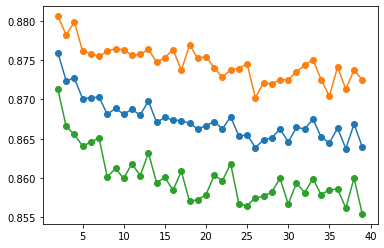

Wall time: 1h 57min 55s


In [22]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range = range(2, 40)
search2 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__n_draws' : param_range})

search2.fit(X_train, y_train)
results = search2.cv_results_['mean_test_score']    
    
print(results)
plt.plot(list(param_range), results, '-o')
plt.plot(list(param_range), results + search2.cv_results_['std_test_score'] , '-o');
plt.plot(list(param_range), results - search2.cv_results_['std_test_score'] , '-o');
plt.show();

Seems like the algorithm favors small samples and not large samples, but above 5 the results are statistically the same

Now we will check how the prior distribution affects the accuracy


[0.8684375  0.86677083 0.87041667 0.86635417 0.86708333 0.866875
 0.86729167 0.86614583 0.85416667]


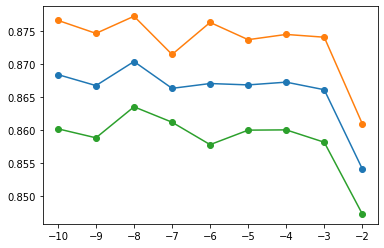

Wall time: 18min 46s


In [23]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range =  range(-10, -1)
search3 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__prior_samples_ratio' : [10**i for i in param_range]})

search3.fit(X_train, y_train)
    
results = search3.cv_results_['mean_test_score']    
    
print(results)
plt.plot(list(param_range), results, '-o')
plt.plot(list(param_range), results + search3.cv_results_['std_test_score'] , '-o');
plt.plot(list(param_range), results - search3.cv_results_['std_test_score'] , '-o');
plt.show();

Seems like the algorithm favors the prior below $10^{-3}$ and within that range the results are not statistically different